# AS - TME6
2018-2019

Binome : Stieban Fernandez, Juliette Ortholand

---

Préparation des données

In [1]:
import sys
sys.path.insert(0, "/users/Enseignants/baskiotis/.local/lib/python3.5/site-packages")

In [2]:
import logging
import torchtext
import torchtext.datasets as datasets
import torchtext.data as data
import torch.nn as nn
import torch

import tensorboard
import tensorboardX
import tensorflow
import spacy
import nltk

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
DATA_DIR="C:\\Users\\Juliette\\Documents\\data_as"

DATASET_DIR="%s/datasets" % DATA_DIR
VECTORS_DIR="%s/vectors" % DATA_DIR

# text
TEXT=data.ReversibleField(lower=True,include_lengths=False,batch_first=True)
LABEL = data.Field(sequential=False, is_target=True)

# make splits for data
train, val, test = datasets.sst.SST.splits(TEXT, LABEL,root=DATASET_DIR)

# Use the vocabulary
wordemb = torchtext.vocab.GloVe("6B", dim=100, cache=VECTORS_DIR)
# Build the vocabularies
# for labels, we use special_first to False so <unk> is last
# (to discard it)
TEXT.build_vocab(train, vectors=wordemb)
LABEL.build_vocab(train, specials_first=False)
train_iter, val_iter, test_iter = data.BucketIterator.splits(
(train, val, test), batch_size=1000, device=0)

nn_embeddings = nn.Embedding.from_pretrained(TEXT.vocab.vectors)

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


In [4]:
TEXT.vocab.vectors.shape

torch.Size([15381, 100])

In [5]:
nn_embeddings

Embedding(15381, 100)

In [6]:
for batch in train_iter:
        t = batch.text # batch_size phrases de max nb mots (taille variable), reste du vecteur complété par 1
        l = batch.label # catégorie de la phrase 
        x = nn_embeddings(t).transpose(1,2) # shape : (batch_size, input_channels, nb_mots_max)
        print(t[:1])
        orig_text = TEXT.reverse(t[2:3])
        print(orig_text)

tensor([[   3,  126,  993,    4,  358,  469,   15,   84, 2464,    4,  675,    5,
          202,    6,  563,   14, 9142,    3,   20,    4,    6,   44,  246,    4,
         4763,   13,    8,    5, 1760,  539,   23,    2,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1]])
['a big , loud , bang-the-drum bore .']
tensor([[  670,    17,    27,   156,     8, 13722,     3,  6522,     7,  1885,
             9,    11,   737,     4,  1243,    13,    46,   203,   276,     8,
           919,     5,    94,   258,     4,  1013,     4,   464,     6,   199,
          3054,   288,     7,    20,   325,     2,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1]])
['speaks eloquently about the symbiotic relationship between art and life .']
tensor([[   5,  284,   35,    9, 1653,   35, 3199,  127,    6,   25, 44

Test

In [14]:
class LSTM(nn.Module):
    
    def __init__(self,inputsize,hidden_size,output_size):
        super(ConvNet1, self).__init__()
        
        #Couches
        self.linF = [nn.Linear(inputsize, hidden_size),nn.Linear(hidden_size, hidden_size)]
        self.linI = [nn.Linear(inputsize, hidden_size),nn.Linear(hidden_size, hidden_size)]
        self.linC = [nn.Linear(inputsize, hidden_size),nn.Linear(hidden_size, hidden_size)]
        self.linO = [nn.Linear(inputsize, hidden_size),nn.Linear(hidden_size, hidden_size)]
        self.linOp = nn.Linear(hidden_size, hidden_size)
        self.sigmoid = nn.sigmoid()
        self.tanh = nn.tanh()
        self.class = nn.Linear(hidden_size, output_size)
        #Variables
        self.hidden_size = hidden_size
    
    def forward(self, X):
        c, h = self.initHidden()
        for _input in X:            
            #Bloc 1
            tmp2 = self.sigmoid(self.linF[0](h)+self.linF[1](_input))
            
            #Bloc 2
            tmp3 = self.sigmoid(self.linI[0](h)+self.linI[1](_input)) \
                    * self.tanh(self.linC[0](h)+self.linC[1](_input))
            
            #Application
            c = (c * tmp2)+ tmp3
            
            #Bloc 3 
            h = self.sigmoid(self.linO[0](h)+self.linO[1](_input)) * self.tanh(self.linOp(c))
        
        out = self.class(h)                                     
                                                          
        return out
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size),torch.zeros(1, self.hidden_size)
    
    
    def score(self,ypred,y):
        score = 0
        if len(y) != len(ypred):
            print('ERREUR')
        for i in range(0,len(y)):
            if y[i] == ypred[i].argmax():
                score += 1
        return(score/len(y))

In [15]:
model = ConvNet1()
loss = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

train_loss = []
val_loss = []

train_score = []
val_score = []


### Train
#--------------------------------------------------------
for i in range(10):
    print(i)
    ####### TRAIN #######
    costs_train = []
    scores_train = []
    for batch in train_iter:
        t = batch.text # batch_size phrases de max nb mots (taille variable), reste du vecteur complété par 1
        l = batch.label # vecteur de 10 
        x = nn_embeddings(t).transpose(1,2) # shape : (batch_size, input_channels, nb_mots_max)

        out = model(x)
        cost = loss(out, l)
        optim.zero_grad()
        cost.backward()
        optim.step()
        costs_train.append(cost)
        scores_train.append(model.score(out, l))
    train_loss.append(torch.tensor(costs_train).mean())
    train_score.append(torch.tensor(scores_train).mean())
    
    ####### VALID #######
    costs_val = []
    scores_val = []
    for k, batch_test in enumerate(test_iter):
        t_test = batch_test.text 
        l_test = batch_test.label 
        x_test = nn_embeddings(t_test).transpose(1,2)

        out_test = model(x_test)
        cost_test = loss(out_test, l_test)
        costs_val.append(cost_test)
        scores_val.append(model.score(out_test,l_test))
    val_score.append(torch.tensor(scores_val).mean())
    val_loss.append(torch.tensor(costs_val).mean())


0
1
2
3
4
5
6
7
8
9


In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.plot(train_loss, c="red", label="train")
plt.plot(val_loss, c="b", label="val")
plt.legend(loc="best")
plt.show()

<Figure size 1000x700 with 1 Axes>

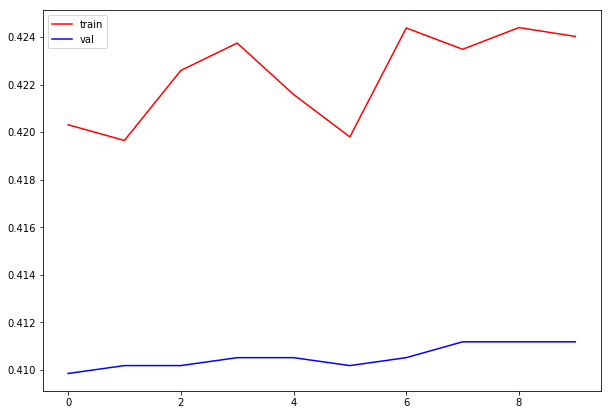

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.plot(train_score, c="red", label="train")
plt.plot(val_score, c="b", label="val")
plt.legend(loc="best")
plt.show()

In [11]:
costs_val = []
scores_val = []
for i, batch in enumerate(val_iter):
    t = batch.text 
    l = batch.label 
    x = nn_embeddings(t).transpose(1,2)

    out = model(x)
    cost = loss(out, l)
    costs_val.append(cost)
    scores_val.append(model.score(out, l))
print(torch.tensor(scores_val).mean())
print(torch.tensor(costs_val).mean())

tensor(0.3778)
tensor(1.0765)


Que se passe-t-il dans un CNN?
- Etude des filtres

Travail en batch

Chaque vecteur correspond a un filtre

Remonter l'information de position, savoir a quelle portion de l'entrée le vecteur fait référence

- Pour chaque phrase, pour chaque composante : max 
- Quels sont les bouts de séquence qui activent le plus le filtre
- $(w_i, s_i) \rightarrow (w,s) \rightarrow (w_o, s_o)$ : voir le stride
- la $j_ième$ sortie correspond à ($j s_o$)... ($j s_o + w_o - 1$)

Qu'est ce qui explique ma classification ?

Quelles sont les parties de ma phrase qui définissent ce qui est positif, negatif, etc

Conv -> max pooling (1 vecteur en sortie) -> softmax

ex : Comment varie l'embedding par rapport à la sortie

- Gradient de la sortie correspondante dans le module linéaire au niveau de softmax le softmax par rapport à l'entrée x
- Si on s'apercçoit que les dérivées sont fortes --> importance

norme du gradient de X par rapport au $j_ième$ vecteur (ne pas oublier requires_grad=True)

Construction d'un réseau

In [46]:
model.conv1[0].weight

Parameter containing:
tensor([[[-0.0006,  0.0215,  0.0179],
         [-0.0152,  0.0186,  0.0448],
         [-0.0487,  0.0577,  0.0520],
         ...,
         [-0.0169,  0.0085, -0.0069],
         [ 0.0288, -0.0336,  0.0259],
         [-0.0533,  0.0347,  0.0032]],

        [[ 0.0437, -0.0335,  0.0232],
         [ 0.0326,  0.0050,  0.0340],
         [-0.0534, -0.0062,  0.0287],
         ...,
         [-0.0218,  0.0131, -0.0524],
         [ 0.0246,  0.0025,  0.0561],
         [ 0.0504,  0.0492, -0.0481]],

        [[ 0.0211,  0.0237, -0.0508],
         [ 0.0046, -0.0282, -0.0494],
         [ 0.0175, -0.0165,  0.0125],
         ...,
         [-0.0139,  0.0368, -0.0545],
         [ 0.0278, -0.0410, -0.0319],
         [ 0.0494,  0.0356,  0.0325]],

        ...,

        [[-0.0369, -0.0216, -0.0466],
         [-0.0316, -0.0408, -0.0082],
         [ 0.0198, -0.0186, -0.0024],
         ...,
         [-0.0470,  0.0311, -0.0069],
         [-0.0112,  0.0474, -0.0062],
         [ 0.0281, -0.0129, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


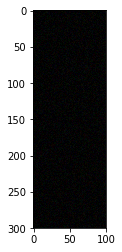

In [29]:
plt.imshow(model.conv1[0].weight.detach().numpy())

# Phrases qui activent le plus le filtre

In [89]:
import copy 
import numpy as np

def extract_sentences(out,t, TEXT, k,f):
    '''out: srtie de la convolution
       t: les phrase en mot de ton batch
       TEXT: fait le lien avec l'ensemble des données
       k: le nombre de phrase
       f: le filtre à étudier'''
    out_mean = copy.copy(out).detach().numpy()
    out_test = out_mean[:,f]
    out_test = np.amax(out_test, axis=1)
    print(out_test.shape)
    list_sentences = []
    plt.imshow(out_mean[:20,f])
    plt.show()
    for i in range(k):
        m = out_test.argmax()
        print(out_mean[m,f].argmax())
        sentence = TEXT.reverse(t[m:m+1].data)
        list_sentences.append(sentence)
        plt.imshow(out_mean[m,f:f+1])
        plt.show()
        print(sentence)
        out_test[m] = -1
        
    return list_sentences

In [108]:
for batch in train_iter:
        t = batch.text # batch_size phrases de max nb mots (taille variable), reste du vecteur complété par 1
        l = batch.label # catégorie de la phrase 
        x = nn_embeddings(t).transpose(1,2) # shape : (batch_size, input_channels, nb_mots_max)
        out = model.conv1(x)
        print(out.shape)
        #list_sentences = extract_sentences(out,t, TEXT, 2,0)
        #list_sentences = extract_sentences(out,t, TEXT, 2,1)
        #list_sentences = extract_sentences(out,t, TEXT, 1,2)
        x.requires_grad = True
        tt = model(x)
        cost = loss(tt, l)
        cost.backward()
        print(x.grad)
        break


torch.Size([1000, 3, 50])
tensor([[[ 0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.0000, -0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000, -0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000, 